# ParSNIP spectra comparison

This notebook examines the spectra that are predicted by the ParSNIP model. We perform all of the following comparisons:
- Predictions of spectra for light curves in the PS1 dataset compared to real observed spectra.
- Predictions of Type Ia supernova spectra in PS1 compared to the SALT2 model.
- Predictions of spectra for PLAsTiCC light curves compared to the spectra that were used in the simulations.

# Load all of the models and data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sncosmo
import lcdata
import astropy.table
from astropy.table import Table
import glob
import gzip

import parsnip

In [2]:
%%time
print("Loading models...")
ps1_model = parsnip.load_model('../models/parsnip_ps1.pt')
plasticc_model = parsnip.load_model('../models/parsnip_plasticc.pt')

print("Loading datasets...")
ps1_dataset = parsnip.load_dataset('../data/ps1.h5')
plasticc_dataset = parsnip.load_dataset('../data/plasticc_test.h5', in_memory=False)

print("Loading predictions...")
ps1_dataset.add_meta(Table.read('../predictions/parsnip_predictions_ps1.h5'))
plasticc_dataset.add_meta(Table.read('../predictions/parsnip_predictions_plasticc_test.h5'))

def load_plasticc_modelpar():
    tables = []
    for modelpar_file in glob.glob('../data/plasticc_modelpar/*.csv'):
        tables.append(Table.read(modelpar_file))

    modelpar_table = astropy.table.vstack(tables)
    modelpar_table['object_id'] = [f'PLAsTiCC {i:09d}' for i in modelpar_table['object_id']]

    # Rename the color column that conflicts with ParSNIP column names.
    modelpar_table.rename_column('color', 'sim_color')
    
    return modelpar_table

print("Loading PLAsTiCC model parameters...")
plasticc_dataset.add_meta(load_plasticc_modelpar())

Loading models...
Loading datasets...
Parsing 'ps1.h5' as PanSTARRS dataset ...
Parsing 'plasticc_test.h5' as PLAsTiCC dataset...
Loading predictions...
Loading PLAsTiCC model parameters...
CPU times: user 51.3 s, sys: 3.01 s, total: 54.4 s
Wall time: 51.7 s


# Compare with real spectra

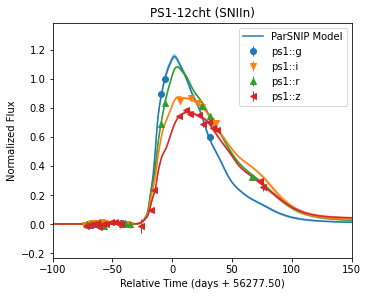

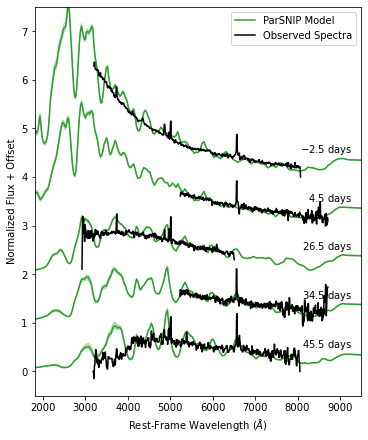

In [3]:
name = 'PS1-12cht'
figure_name = 'ps1_12cht'

lc = ps1_dataset.get_lc(object_name=name)

parsnip.plot_light_curve(lc, ps1_model, normalize_flux=True)
plt.title(f"{name} ({lc.meta['type']})")
plt.xlim(-100, 150)
plt.savefig(f'./figures/lc_{figure_name}.pdf')

parsnip.plotting.plot_sne_space(
    lc,
    ps1_model,
    name,
    time_diff=5.,
    label_wave=9300.,
    label_offset=0.5,
)

plt.xlim(1800., 9500.)
plt.ylim(-0.5, 7.5)
plt.savefig(f'./figures/spectra_{figure_name}.pdf')

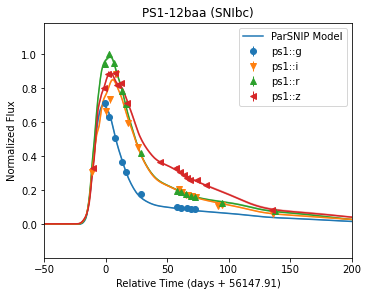

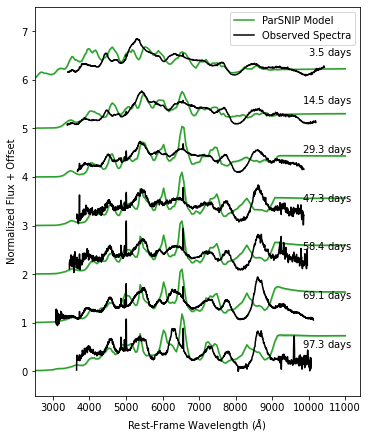

In [4]:
name = 'PS1-12baa'
figure_name = 'ps1_12baa'

lc = ps1_dataset.get_lc(object_name=name)

parsnip.plot_light_curve(lc, ps1_model, normalize_flux=True)
plt.title(f"{name} ({lc.meta['type']})")
plt.xlim(-50, 200)
plt.savefig(f'./figures/lc_{figure_name}.pdf')

parsnip.plotting.plot_sne_space(
    lc,
    ps1_model,
    name,
    min_wave=4000.,
    max_wave=8000.,
    time_diff=10.,
    max_time=100.,
    source='2019MNRAS.482.1545S,2012MNRAS.425.1789S',
    label_wave=11200.,
    label_offset=0.5,
)
plt.xlim(2500., 11400.)
plt.ylim(-0.5, 7.5)
plt.savefig(f'./figures/spectra_{figure_name}.pdf')

# Compare with models

## Comparison with ParSNIP fit compared to the best SALT2 fit for a PS1 SN Ia

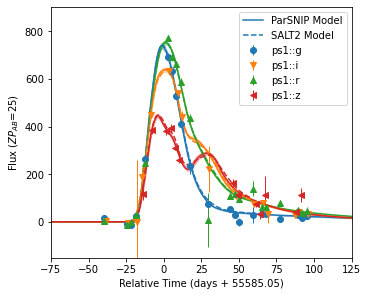

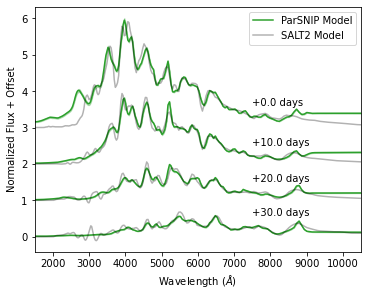

In [5]:
lc = ps1_dataset.get_lc(object_name='PS1-11bk')
lc = parsnip.preprocess_light_curve(lc, ps1_model.settings)

obs = lcdata.to_sncosmo(lc)
salt_model = sncosmo.Model(source='salt2-extended')
salt_model['z'] = lc.meta['redshift']
salt_model['t0'] = lc.meta['parsnip_reference_time']
result, fitted_model = sncosmo.fit_lc(obs, salt_model, ['t0', 'x0', 'x1', 'c'],
                                      bounds={'x1': (-10, 10), 'c': (-10, 10)})

parsnip.plot_light_curve(lc, ps1_model, sncosmo_model=fitted_model, 
                         sncosmo_label='SALT2 Model')
plt.xlim(-75, 125)
plt.savefig('./figures/snia_lc.pdf', dpi=300)

parsnip.plot_spectra(lc, ps1_model, sncosmo_model=fitted_model, flux_scale=4.,
                     sncosmo_label='SALT2 Model', spectrum_label_offset=0.3)
plt.xlim(1500, 10500)
plt.savefig('./figures/snia_spectrum.pdf', dpi=300)

## Comparison with PLAsTiCC Simulations

In [6]:
# Load an SNANA model for a given PLAsTiCC light curve.
# The model parameters in PLAsTiCC tend to be close but not quite right for some reason.
# To get around this, we fit the model back to the light curve. As the light curve was
# generated from this model, the fit should be close to perfect.

model_libs_basedir = '/astro/store/epyc/users/kyboone/plasticc/model_libs/'

def load_snana_map(path, idx_col, file_col, skip_header=0):
    map_data = np.genfromtxt(path, skip_header=skip_header, dtype=None, encoding='utf8')
    file_map = {i[f'f{idx_col}']: i[f'f{file_col}'] for i in map_data}
    return file_map

kn_file_map = load_snana_map(f'{model_libs_basedir}/SIMSED.KN-K17/SED.INFO', 2, 1, skip_header=8)
snibc_nonia_map = load_snana_map(f'{model_libs_basedir}/NON1ASED.SNIbc-Templates/NON1A.LIST', 1, 3)
snii_nonia_map = load_snana_map(f'{model_libs_basedir}/NON1ASED.SNII-Templates/NON1A.LIST', 1, 3)

def load_snana_model(lc):
    # Trim to near peak or bad stuff happens when the model goes to zero
    lc = lc[(lc['time'] > lc.meta['true_peakmjd'] - 20) & (lc['time'] < lc.meta['true_peakmjd'] + 50)]
    
    path = None

    if lc.meta['type'] == 'SLSN-I':
        path = f"SIMSED.SLSN-I-MOSFIT/slsn{lc.meta['SLSN_INDEX']}.dat.gz"
    elif lc.meta['type'] == 'SNII':
        if lc.meta['submodel'] == 1:
            path = 'NON1ASED.SNII-Templates/' + snii_nonia_map[lc.meta['non1a_template_index']] + '.gz'
        elif lc.meta['submodel'] == 2:
            path = (f"SIMSED.SNII-NMF/IINMF_PC1-{int(lc.meta['pc1']*10)}_"
                    f"PC2-{int(lc.meta['pc2']*100)}_PC3-{int(lc.meta['pc3']*100)}.SED.gz")
        else:
            path = f"SIMSED.SNIIn-MOSFIT/csm_{lc.meta['IIN_INDEX']}.dat.gz"
    elif lc.meta['type'] == 'SNIbc':
        if lc.meta['submodel'] == 1:
            path = 'NON1ASED.SNIbc-Templates/' + snibc_nonia_map[lc.meta['non1a_template_index']] + '.gz'
        else:
            path = f"SIMSED.SNIbc-MOSFIT/ibc_{lc.meta['IBC_INDEX']}.dat.gz"
    elif lc.meta['type'] == 'KN':
        path = 'SIMSED.KN-K17/' + kn_file_map[lc.meta['KN_INDEX']] + '.gz'

    if path is None:
        raise ValueError("Can't handle this light curve type.")

    source_data = source = sncosmo.read_griddata_ascii(gzip.open(
        model_libs_basedir + path,
        'rt'
    ))
    
    lc = lcdata.to_sncosmo(lc)

    model = sncosmo.Model(
        source=sncosmo.TimeSeriesSource(*source_data),
        effects=[sncosmo.F99Dust()],
        effect_names=['host'],
        effect_frames=['rest'],
    )

    # The recorded peakmjd values are slightly off for some reason, and the amplitude is
    # near impossible to reconstruct. Fit for these parameters. This should be a near
    # perfect fit because the data were generated from this model.
    model['t0'] = lc.meta['true_peakmjd']
    model['z'] = lc.meta['redshift']
    model['hostebv'] = lc.meta['true_av'] / 3.1
    res, fitted_model = sncosmo.fit_lc(lc, model, ['t0', 'amplitude'])

    return fitted_model

def plot_lc_spectra(lc_name, flux_scale=4.):
    # Simulated model of a SN II
    lc = plasticc_dataset.get_lc(lc_name)
    snana_model = load_snana_model(lc)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
    
    title = f"{lc_name} - {lc.meta['type']} - {lc.meta['submodel']}"
    fig.suptitle(title)

    parsnip.plot_light_curve(lc, plasticc_model, sncosmo_model=snana_model, 
                             sncosmo_label='Simulated Model', ax=ax1)
    ax1.set_xlim(-100, 150)
    parsnip.plot_spectra(lc, plasticc_model, sncosmo_model=snana_model,
                         flux_scale=flux_scale, sncosmo_label='Simulated Model', ax=ax2)

/astro/store/epyc/users/kyboone/sncosmo/sncosmo/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


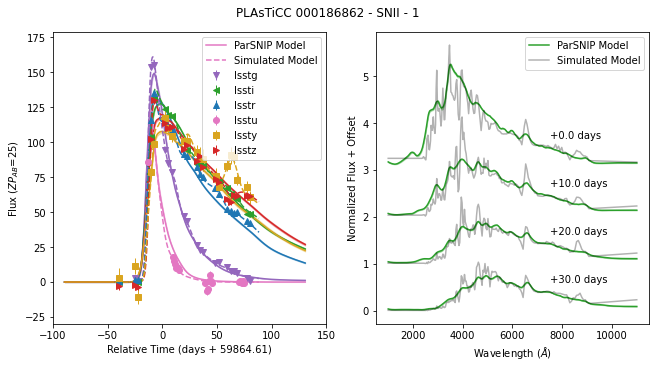

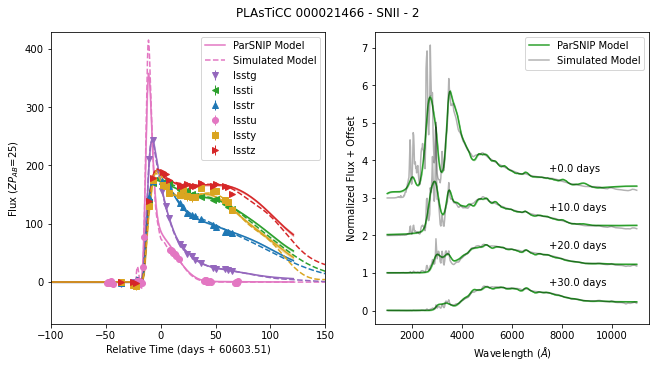

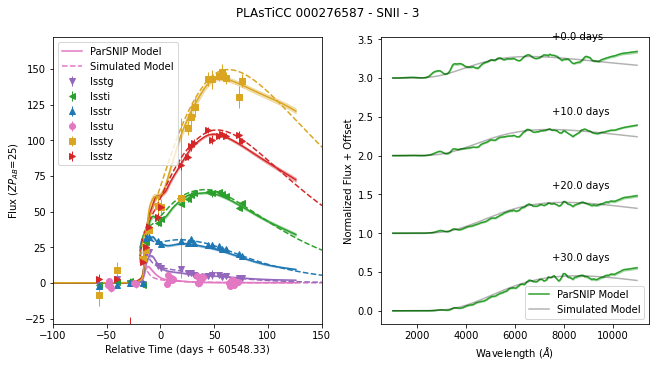

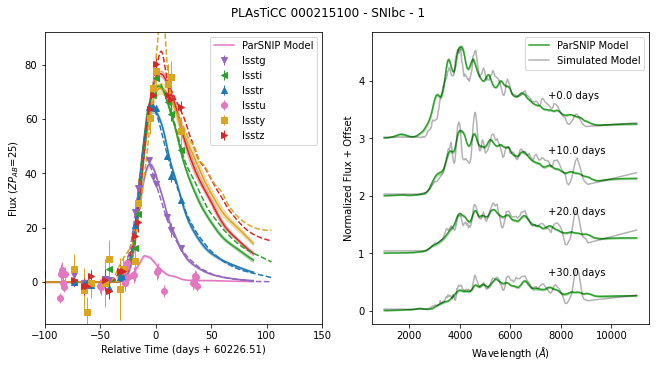

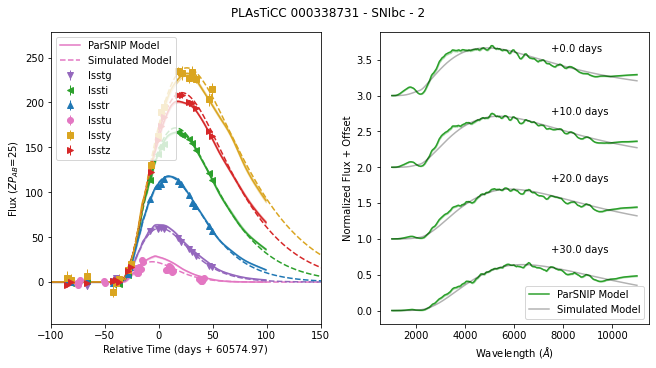

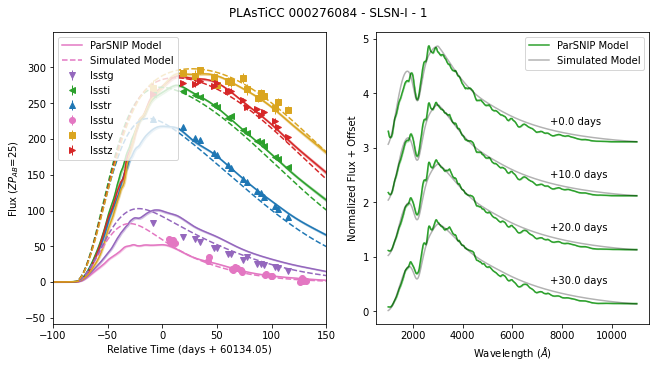

In [7]:
# Show a bunch of different examples of spectral models for
# well-observed light curves with good ParSNIP fits.

# SNII
plot_lc_spectra('PLAsTiCC 000186862')
plot_lc_spectra('PLAsTiCC 000021466')
plot_lc_spectra('PLAsTiCC 000276587')

# SNIbc
plot_lc_spectra('PLAsTiCC 000215100')
plot_lc_spectra('PLAsTiCC 000338731')

# SLSN-I
plot_lc_spectra('PLAsTiCC 000276084')

/astro/store/epyc/users/kyboone/sncosmo/sncosmo/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: lsstu(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


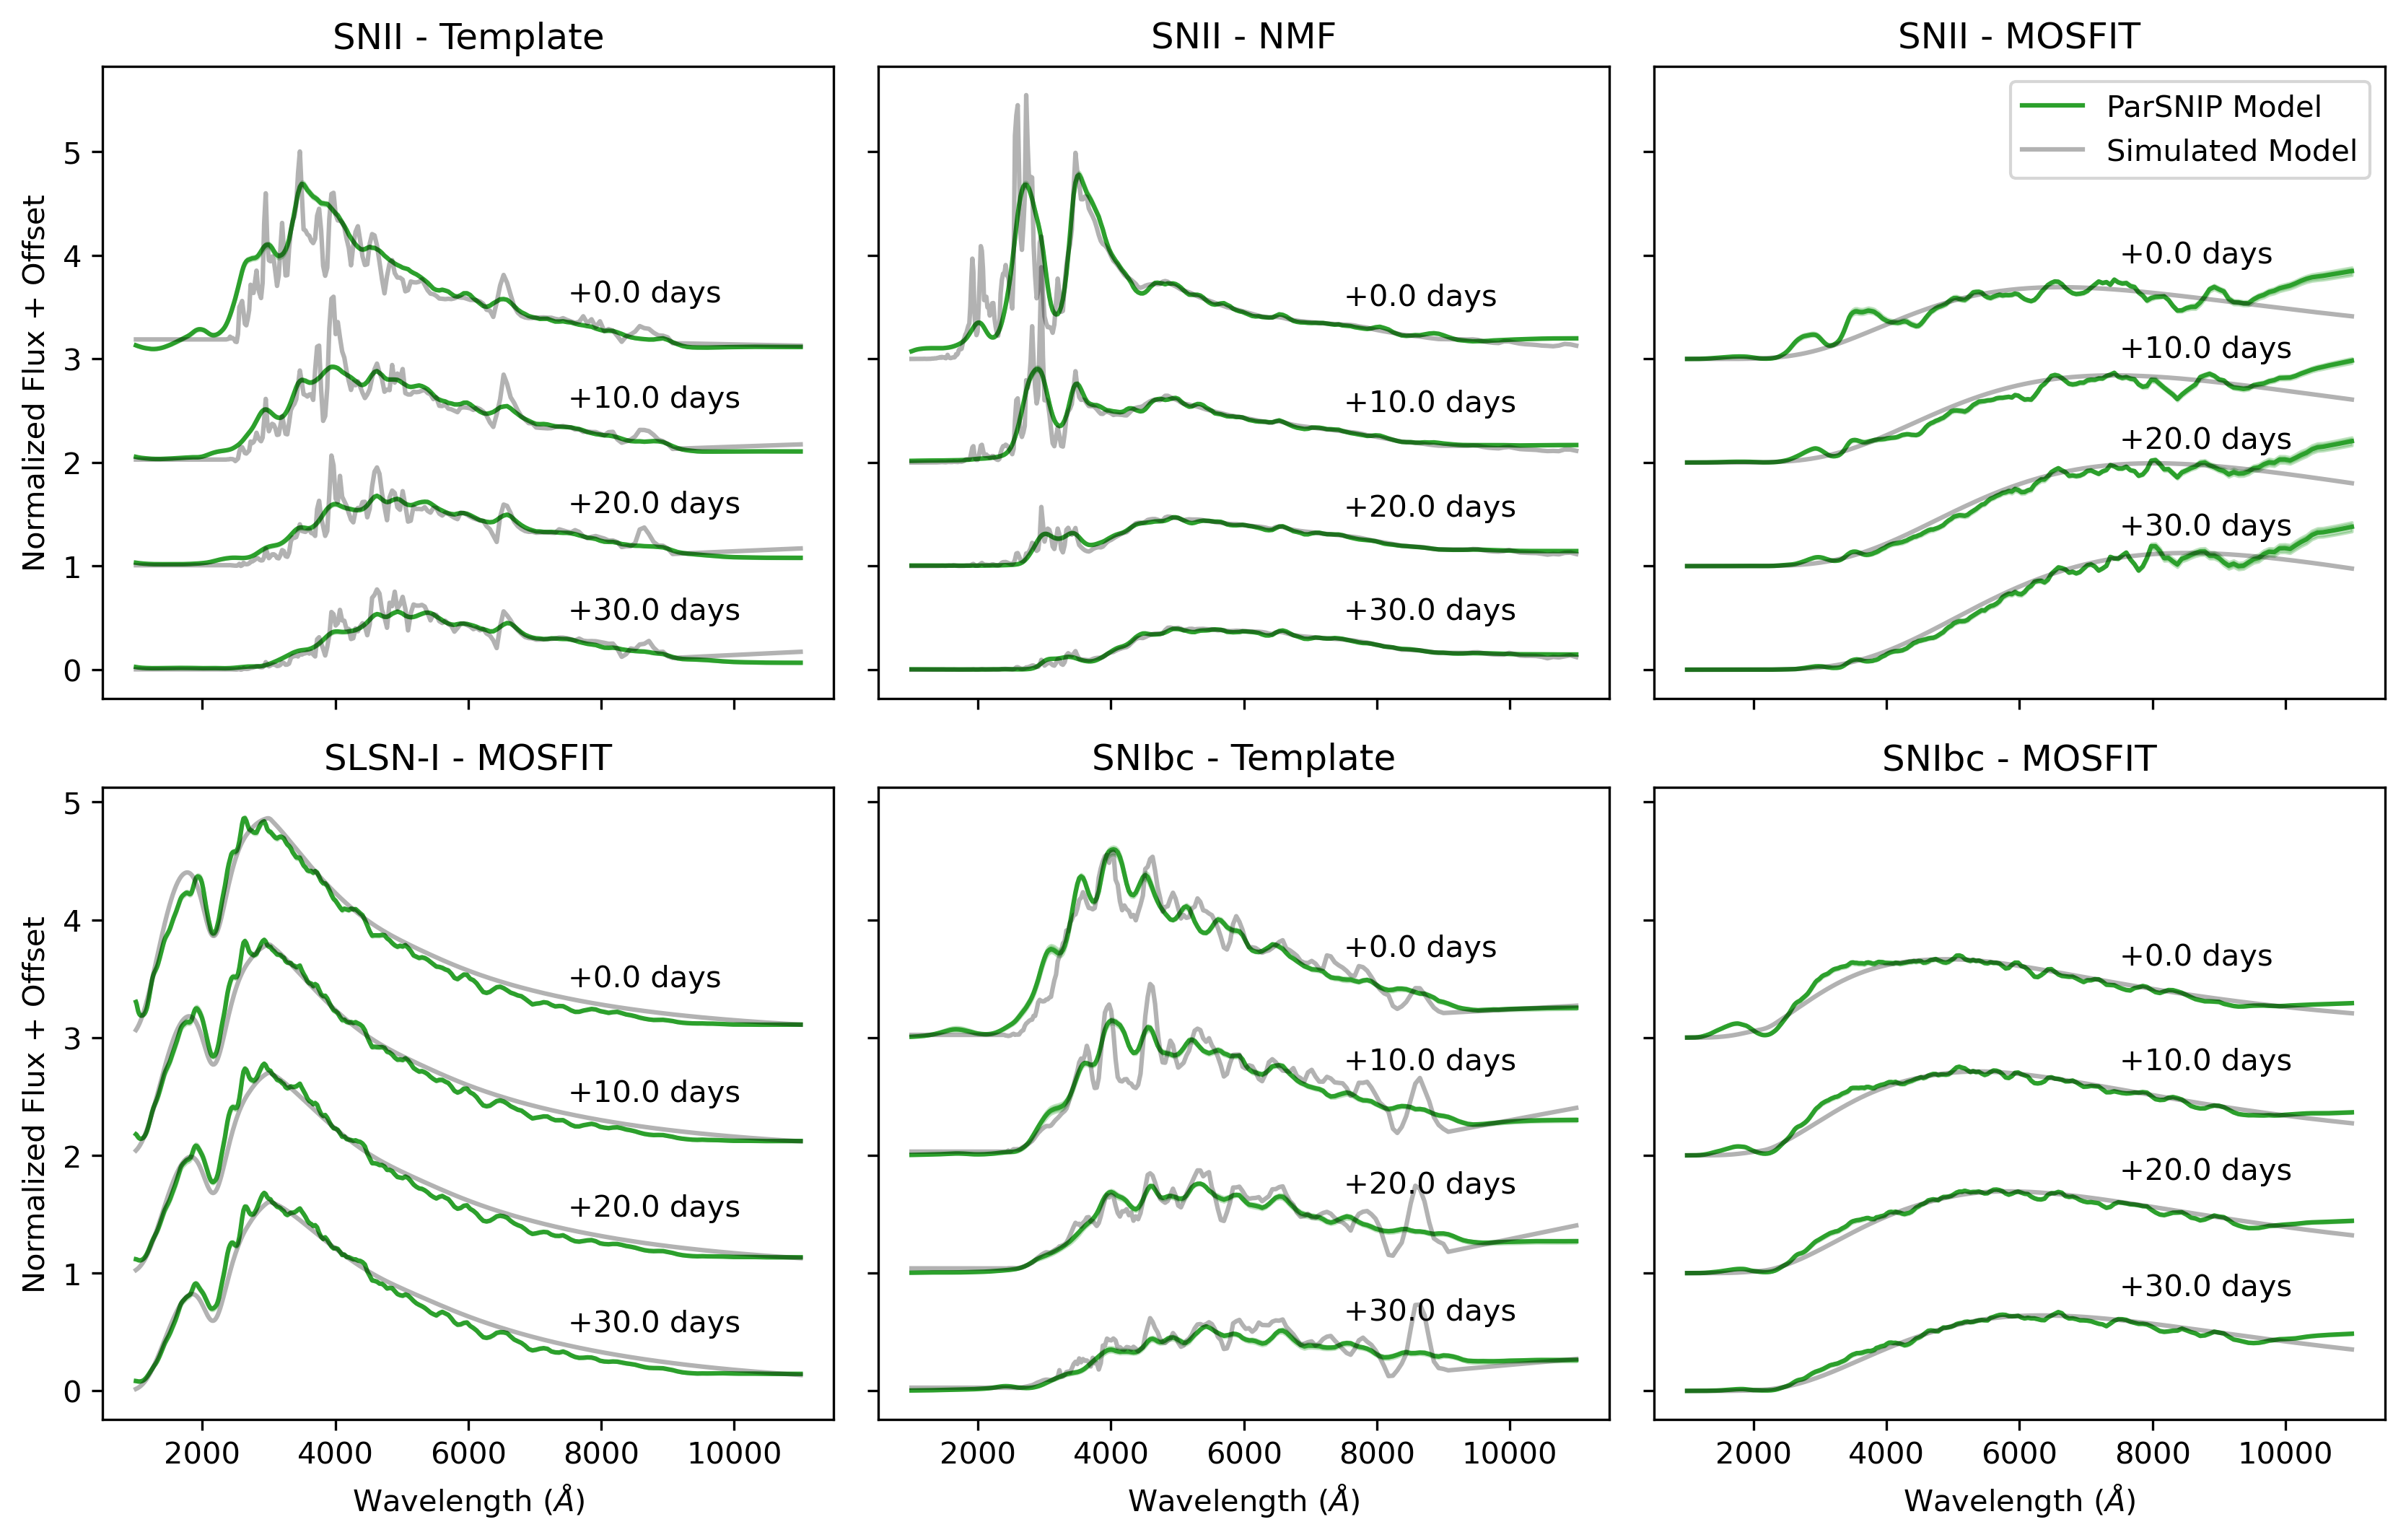

In [8]:
# Combined plot for the paper
fig, axes = plt.subplots(2, 3, figsize=(11, 7), sharex=True, sharey='row',
                         dpi=300, gridspec_kw={'wspace': 0.1}, constrained_layout=True)

def plot_grid_spectra(lc_name, title, ax, flux_scale=4., **kwargs):
    lc = plasticc_dataset.get_lc(lc_name)
    snana_model = load_snana_model(lc)
    parsnip.plot_spectra(lc, plasticc_model, sncosmo_model=snana_model, sncosmo_label='Simulated Model',
                         ax=ax, flux_scale=flux_scale, **kwargs)
    ax.set_title(title)
    #ax.set_title(f"{title} [{lc.meta['s1']:.1f}, {lc.meta['s2']:.1f}, {lc.meta['s3']:.1f}]")
    if ax not in axes[1]:
        ax.set_xlabel(None)
    if ax is not axes[0][2]:
        ax.get_legend().remove()
    if ax not in [axes[0][0], axes[1][0]]:
        ax.set_ylabel(None)

plot_grid_spectra('PLAsTiCC 000186862', title='SNII - Template', flux_scale=3., ax=axes[0][0])
plot_grid_spectra('PLAsTiCC 000021466', title='SNII - NMF', flux_scale=2.5, ax=axes[0][1])
plot_grid_spectra('PLAsTiCC 000276587', title='SNII - MOSFIT', flux_scale=10., ax=axes[0][2])

plot_grid_spectra('PLAsTiCC 000276084', title='SLSN-I - MOSFIT', ax=axes[1][0])
plot_grid_spectra('PLAsTiCC 000215100', title='SNIbc - Template', ax=axes[1][1])
plot_grid_spectra('PLAsTiCC 000338731', title='SNIbc - MOSFIT', ax=axes[1][2])

fig.savefig('./figures/spectra_plasticc_comparison.pdf')